In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("LoadParquet").getOrCreate()

parquet_path = "/content/drive/MyDrive/pubmed_data/df_pubmed.parquet"

df_pubmed = spark.read.parquet(parquet_path)

df_pubmed.show()

Mounted at /content/drive
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|
+--------+--------------------+--------------------+----+--------------------+--------------------+-----------

In [ ]:
df_pubmed.count()

24919

In [ ]:
df_pubmed.show(truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="cleaned_tokens", outputCol="raw_features", vocabSize=5000, minDF=10.0)

cvmodel = cv.fit(df_pubmed)

result_cv = cvmodel.transform(df_pubmed)

result_cv.show()

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|        raw_features|
+--------+--------------------+--------------------+----+--------------------+----------------

In [ ]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)
result_tfidf.show()

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+--------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|        raw_features|            features|
+--------+--------------------+--------------------+

In [ ]:
from pyspark.ml.clustering import LDA
num_topics = 10
max_iterations = 100

lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf)
lda_result_df = lda_model.transform(result_tfidf)
print("--- Dataset with LDA results ---")
lda_result_df.show()

--- Dataset with LDA results ---
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+--------------------+--------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|        raw_features|            features

In [ ]:
topicIndices = lda_model.describeTopics(maxTermsPerTopic = 10)
vocabList = cvmodel.vocabulary

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

Topic ID:0
species
genome
genetics
genetic
environmental
sequence
sequencing
dna
animals
genes
------------------
Topic ID:1
care
health
practice
patient
standards
medical
quality
services
united
training
------------------
Topic ID:2
95
ci
retrospective
0
patients
outcome
aged
7
9
epidemiology
------------------
Topic ID:3
administration
blood
dosage
drug
agents
therapy
serum
mg
anti
therapeutic
------------------
Topic ID:4
cells
expression
cell
metabolism
protein
mice
animals
regulation
proteins
gene
------------------
Topic ID:5
psychology
participants
health
adult
young
surveys
social
female
questionnaires
adolescent
------------------
Topic ID:6
based
paper
proposed
approach
applications
methods
method
research
new
systems
------------------
Topic ID:7
chemistry
chemical
compounds
acid
structure
properties
water
molecular
synthesis
surface
------------------
Topic ID:8
diagnostic
imaging
heart
artery
0
cardiac
p
aged
middle
male
------------------
Topic ID:9
case
rare
old
patient

In [ ]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

lda_result_df = lda_result_df.withColumn("topic_array", vector_to_array("topicDistribution"))

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

    topic_df = lda_result_df.filter(col("topic_array")[topic["topic"]] > 0.8)
    print("PMIDs for this topic:")
    topic_df.select("PMID").show(truncate=False)
    print("==================")


Topic ID:0
species
genome
genetics
genetic
environmental
sequence
sequencing
dna
animals
genes
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343856|
|28344024|
|28344035|
|28344106|
|28344109|
|28344193|
|28344392|
|28344410|
|28344591|
|28344976|
|28345044|
|28345058|
|28345060|
|28345194|
|28345224|
|28345274|
|28345277|
|28345506|
|28345507|
|28345615|
+--------+
only showing top 20 rows

Topic ID:1
care
health
practice
patient
standards
medical
quality
services
united
training
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343699|
|28343700|
|28343712|
|28343750|
|28344140|
|28344693|
|28344722|
|28345472|
|28345977|
|28345989|
|28346035|
|28346601|
|28346625|
|28346626|
|28347440|
|28348735|
|28349576|
|28350222|
|28350223|
|28350236|
+--------+
only showing top 20 rows

Topic ID:2
95
ci
retrospective
0
patients
outcome
aged
7
9
epidemiology
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343

Topic 0


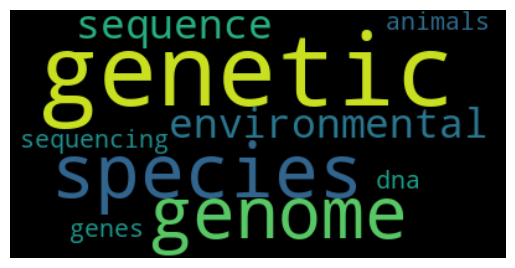

Topic 1


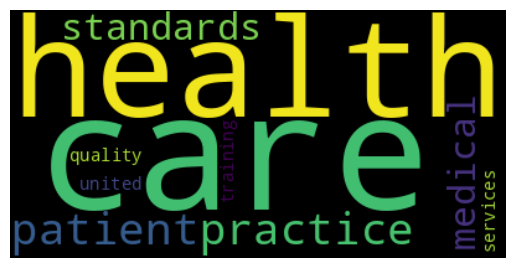

Topic 2


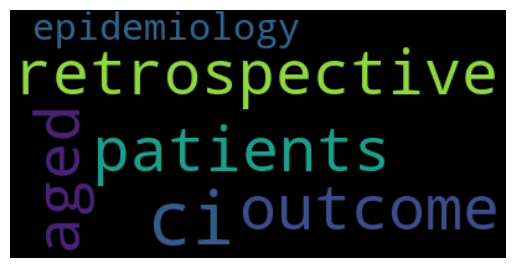

Topic 3


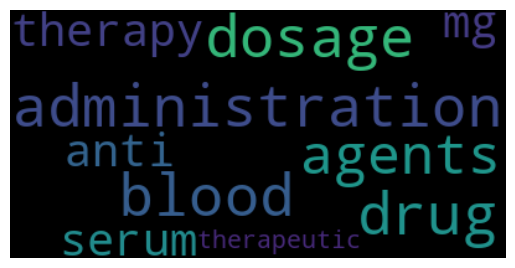

Topic 4


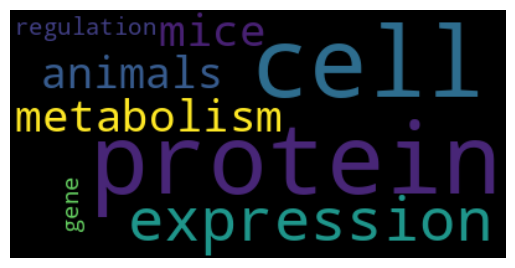

Topic 5


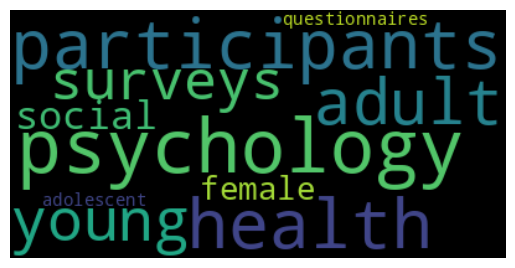

Topic 6


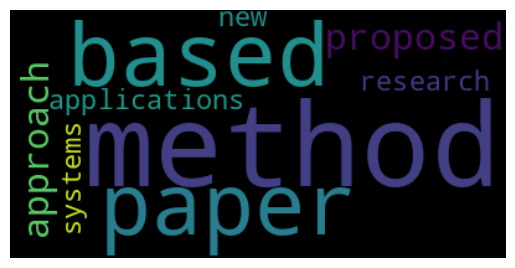

Topic 7


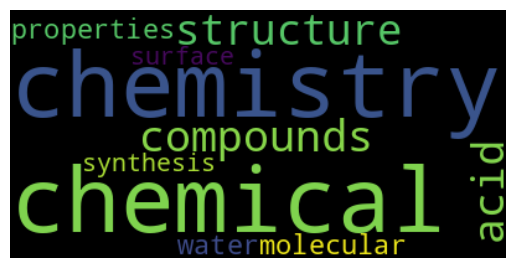

Topic 8


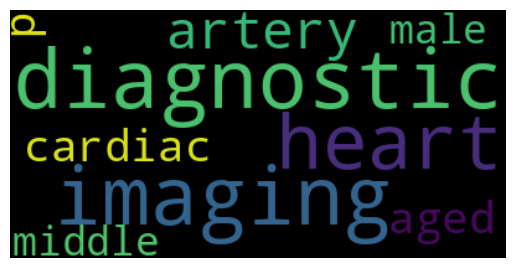

Topic 9


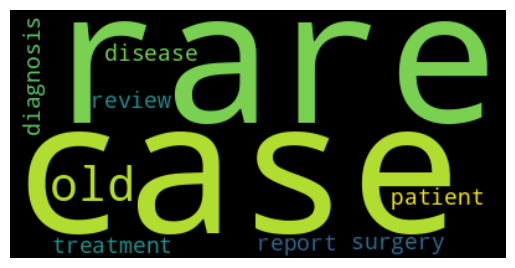

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

word_topic = topicIndices.rdd.map(lambda row: [vocabList[i] for i in row.termIndices]).collect()

for i in range(len(word_topic)):
    print("Topic {}".format(i))
    wordcloud = WordCloud().generate(" ".join(word_topic[i]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
from pyspark.sql.functions import explode, posexplode, udf
from pyspark.sql.types import IntegerType


# Step 1: Extract top topic for each PMID
lda_df = lda_result_df.select("PMID", "topicDistribution")
get_top_topic = udf(lambda v: int(v.argmax()), IntegerType())
top_topic_df = lda_df.withColumn("top_topic", get_top_topic("topicDistribution"))

# Step 2: Create edges between PMIDs that share the same dominant topic
edges = top_topic_df.alias("df1").join(
    top_topic_df.alias("df2"),
    (col("df1.top_topic") == col("df2.top_topic")) & (col("df1.PMID") < col("df2.PMID"))
).select(
    col("df1.PMID").alias("src"),
    col("df2.PMID").alias("dst"),
    col("df1.top_topic").alias("topic")
)

# Step 3: Create vertex DataFrame
vertices = top_topic_df.select(col("PMID").alias("id")).distinct()


In [ ]:
vertices.show()

+--------+
|      id|
+--------+
|28343726|
|28344084|
|28344903|
|28345049|
|28345050|
|28345245|
|28345914|
|28346009|
|28346278|
|28346353|
|28346359|
|28346511|
|28346896|
|28347022|
|28347167|
|28347230|
|28347349|
|28347719|
|28347854|
|28348266|
+--------+
only showing top 20 rows



In [ ]:
edges.show()

+--------+--------+-----+
|     src|     dst|topic|
+--------+--------+-----+
|28299189|28374240|    4|
|28299189|28374162|    4|
|28299189|28374152|    4|
|28299189|28374151|    4|
|28299189|28374150|    4|
|28299189|28374143|    4|
|28299189|28374134|    4|
|28299189|28374123|    4|
|28299189|28374099|    4|
|28299189|28374082|    4|
|28299189|28374070|    4|
|28299189|28374069|    4|
|28299189|28374012|    4|
|28299189|28374011|    4|
|28299189|28373966|    4|
|28299189|28373885|    4|
|28299189|28373873|    4|
|28299189|28373872|    4|
|28299189|28373868|    4|
|28299189|28373847|    4|
+--------+--------+-----+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="stemmed_tokens", outputCol="stemmed_raw_features", vocabSize=5000, minDF=10.0)

cvmodel = cv.fit(df_pubmed)

result_cv = cvmodel.transform(df_pubmed)

result_cv.show()

from pyspark.ml.feature import IDF

idf = IDF(inputCol="stemmed_raw_features", outputCol="stemmed_features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)
result_tfidf.show()

from pyspark.ml.clustering import LDA
num_topics = 10
max_iterations = 100

lda = LDA(k=num_topics, maxIter=max_iterations, featuresCol="stemmed_features")
lda_model = lda.fit(result_tfidf)
lda_result_df = lda_model.transform(result_tfidf)
print("--- Dataset with LDA results ---")
lda_result_df.show()

topicIndices = lda_model.describeTopics(maxTermsPerTopic = 10)
vocabList = cvmodel.vocabulary

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|stemmed_raw_features|
+--------+--------------------+--------------------+----+--------------------+----------------

In [ ]:
topicIndices = lda_model.describeTopics(maxTermsPerTopic = 10)
vocabList = cvmodel.vocabulary

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

Topic ID:0
rat
anim
neuron
arteri
diseas
brain
inject
diabet
blood
drug
------------------
Topic ID:1
age
patient
year
0
outcom
p
middl
retrospect
femal
95
------------------
Topic ID:2
genet
sequenc
gene
genom
infect
protein
pathogen
dna
mutat
isol
------------------
Topic ID:3
health
research
survey
practic
psycholog
educ
care
review
need
servic
------------------
Topic ID:4
structur
materi
chemistri
properti
electron
surfac
applic
nanoparticl
the
metal
------------------
Topic ID:5
cell
express
regul
protein
signal
inhibit
activ
tumor
receptor
induc
------------------
Topic ID:6
neoplasm
cancer
tumor
stage
patient
carcinoma
patholog
chemotherapi
prognosi
depress
------------------
Topic ID:7
imag
comput
measur
algorithm
method
model
perform
propos
simul
visual
------------------
Topic ID:8
food
diet
nutrit
feed
supplement
dietari
reproduct
vitamin
intak
hormon
------------------
Topic ID:9
concentr
antioxid
plant
oxid
extract
water
pollut
product
chemistri
compound
-----------------

In [ ]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

lda_result_df = lda_result_df.withColumn("topic_array", vector_to_array("topicDistribution"))

for topic in topicIndices.collect():
    print("Topic ID:" + str(topic["topic"]))
    for term in topic["termIndices"]:
        print(vocabList[term])
    print("------------------")

    topic_df = lda_result_df.filter(col("topic_array")[topic["topic"]] > 0.8)
    print("PMIDs for this topic:")
    topic_df.select("PMID").show(truncate=False)
    print("==================")

Topic ID:0
rat
anim
neuron
arteri
diseas
brain
inject
diabet
blood
drug
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28344023|
|28344916|
|28347261|
|28348661|
|28348701|
|28349068|
|28351550|
|28351964|
|28352392|
|28352413|
|28352432|
|28353077|
|28353311|
|28356047|
|28356665|
|28357015|
|28357025|
|28359821|
|28359933|
|28360013|
+--------+
only showing top 20 rows

Topic ID:1
age
patient
year
0
outcom
p
middl
retrospect
femal
95
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343828|
|28344020|
|28344141|
|28344144|
|28344423|
|28344617|
|28344792|
|28344941|
|28344945|
|28344956|
|28344957|
|28344964|
|28344965|
|28345070|
|28345072|
|28345139|
|28345276|
|28345314|
|28345539|
|28345542|
+--------+
only showing top 20 rows

Topic ID:2
genet
sequenc
gene
genom
infect
protein
pathogen
dna
mutat
isol
------------------
PMIDs for this topic:
+--------+
|PMID    |
+--------+
|28343913|
|28343961|
|28344037|
|28344080|
|2834416

For each topic from an LDA model and retrieves the PMIDs (PubMed IDs) of documents that have a high probability (>0.8) of belonging to each topic.

Topic 0


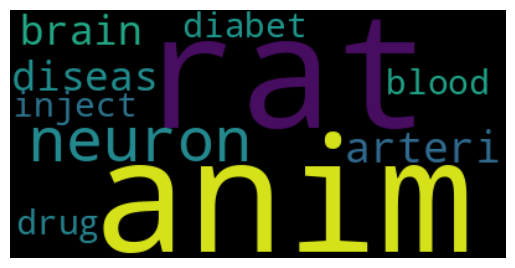

Topic 1


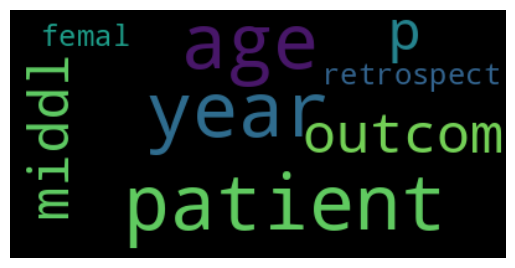

Topic 2


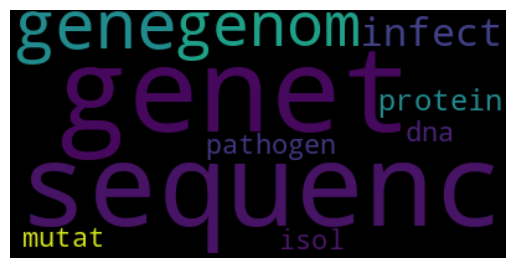

Topic 3


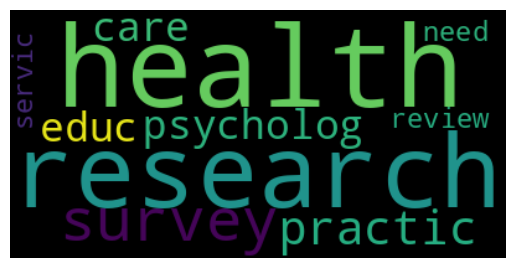

Topic 4


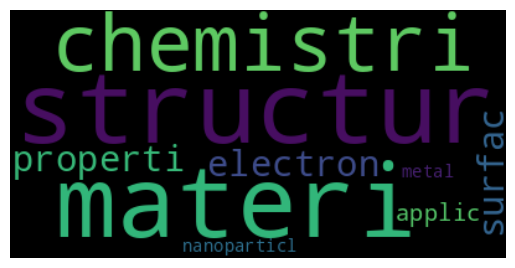

Topic 5


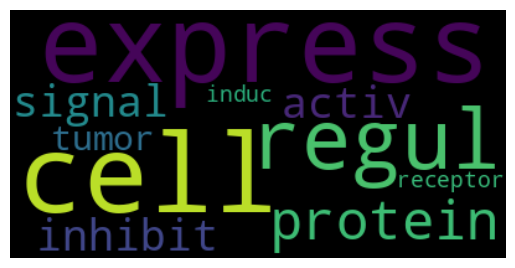

Topic 6


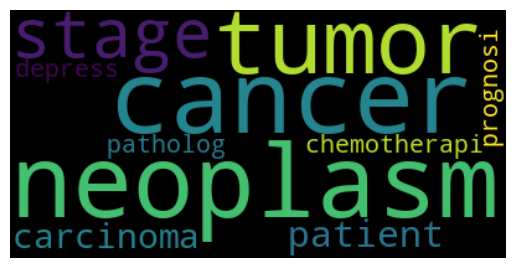

Topic 7


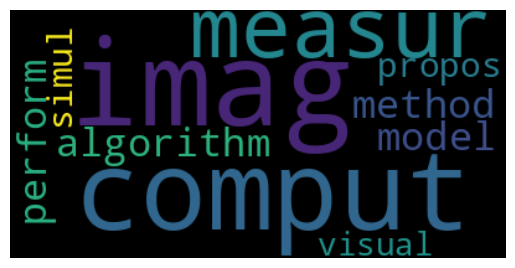

Topic 8


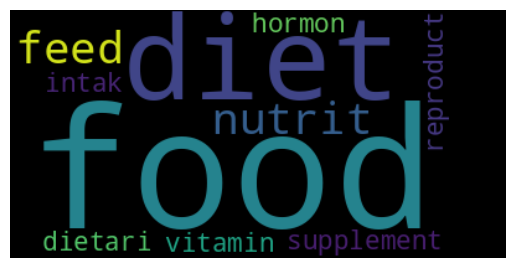

Topic 9


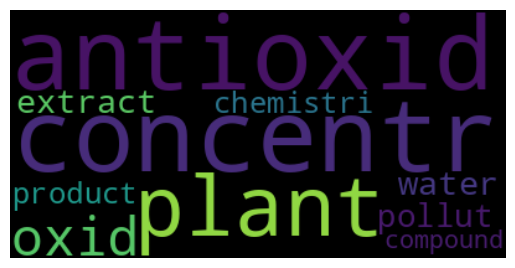

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

word_topic = topicIndices.rdd.map(lambda row: [vocabList[i] for i in row.termIndices]).collect()

for i in range(len(word_topic)):
    print("Topic {}".format(i))
    wordcloud = WordCloud().generate(" ".join(word_topic[i]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

The topic modeling results reveal a diverse and well-structured thematic organization of biomedical literature, with each topic highlighting distinct areas of scientific focus. Topic 0 emphasizes animal-based experimental research, featuring terms like rat, neuron, brain, and diabet, suggesting studies involving neurological or vascular responses in animal models. Topic 1 centers on clinical outcomes and demographics, with frequent mentions of age, patient, year, and retrospect, pointing to retrospective human studies with statistical analysis. Topic 2 is rooted in genomics and infectious disease, combining terms such as gene, dna, mutat, and pathogen, indicative of genetic sequencing and pathogen identification research. Topic 5 and Topic 6 delve into molecular biology and oncology, with Topic 5 highlighting protein, signal, tumor, and receptor, and Topic 6 emphasizing cancer, chemotherapi, and prognosi, covering both mechanistic and clinical aspects of cancer research. Topic 3 leans toward public health and healthcare services, with terms like survey, care, psycholog, and educ, while Topic 4 reflects materials science and nanotechnology. Meanwhile, Topic 7 captures the realm of computational modeling and medical imaging, and Topic 8 relates to nutrition and reproductive health, referencing diet, feed, and vitamin. Finally, Topic 9 covers environmental chemistry and plant-based compounds, with a focus on antioxid, pollut, and extract. These findings illustrate the breadth of topics in biomedical research and demonstrate the effectiveness of LDA in uncovering coherent thematic clusters.

In [ ]:
from pyspark.sql.functions import col, round
from pyspark.ml.functions import vector_to_array

lda_result_df = lda_result_df.withColumn("topic_array", vector_to_array("topicDistribution"))

test_pmids = lda_result_df.filter(
    (col("topic_array")[2] > 0.8)).select(
    "PMID",
    round(col("topic_array")[2], 2).alias("Topic_2_Prob"),
)

test_pmids.show(20, truncate=False)


+--------+------------+
|PMID    |Topic_2_Prob|
+--------+------------+
|28343913|0.84        |
|28343961|0.89        |
|28344037|0.93        |
|28344080|0.85        |
|28344161|0.83        |
|28344191|0.92        |
|28344583|0.91        |
|28345006|0.82        |
|28345032|0.87        |
|28345194|0.95        |
|28345277|1.0         |
|28345293|0.81        |
|28345654|1.0         |
|28345672|1.0         |
|28345815|0.88        |
|28345992|0.85        |
|28346143|0.96        |
|28346509|0.89        |
|28346704|0.87        |
|28346745|0.84        |
+--------+------------+
only showing top 20 rows



Filter and display PMIDs of documents with a high probability (> 0.8) of belonging to Topic 2.


In [ ]:
df_test = test_pmids.join(df_pubmed, on="PMID", how="left")

columns_to_display = ["PMID", "Title", "Abstract", "Topic_2_Prob", "stemmed_tokens"]

df_test.select(columns_to_display).show(10, truncate=False)


+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_test.count()

517

In [ ]:
from pyspark.sql.functions import split, explode, lower, regexp_replace, col

df_words = df_test.select(explode(col("stemmed_tokens")).alias("word"))

df_words = df_words.filter((col("word") != "") & (col("word").isNotNull()))
df_words.groupBy("word").count().orderBy(col("count").desc()).show(20, truncate=False)


+--------+-----+
|word    |count|
+--------+-----+
|genet   |576  |
|gene    |448  |
|genom   |415  |
|protein |415  |
|sequenc |407  |
|use     |330  |
|studi   |299  |
|major   |292  |
|identifi|223  |
|function|222  |
|metabol |221  |
|human   |217  |
|express |209  |
|cell    |205  |
|regul   |202  |
|analysi |196  |
|result  |191  |
|specif  |189  |
|pathogen|188  |
|differ  |187  |
+--------+-----+
only showing top 20 rows



The documents with high probability for Topic 2 consistently emphasize core biological terms like genet, gene, genom, sequenc, protein, and pathogen, confirming that this topic represents research in genetics, genome sequencing, protein expression, and infectious disease identification.